In [36]:
import sys
# Before using tensorflow:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras.backend as KB
from matplotlib import pylab as plt
import tensorflow.keras
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

import pickle
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Tensor Flow Version: 2.3.2
Keras Version: 2.4.0

Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
GPU is NOT AVAILABLE


## Create model

In [37]:
import tensorflow
from client.models.AMLmodel import construct_model

model = construct_model()

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      1184      
_________________________________________________________________
activation_18 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 49, 49, 64)       

## Load training data

In [39]:
import numpy as np
from client.data.datagenerator import DataGenerator
labels0 = np.load('dataset/processed/data_partitions/partition0/labels.npy', allow_pickle=True).item()

data_path0 = 'dataset/processed/data_partitions/partition0/data_singlets'

ids0 = [l for l in labels0]
np.random.shuffle(ids)
train_split_index = int(len(ids0)*0.9)
train_ids = ids0[:train_split_index]
val_ids = ids0[train_split_index:]

train_gen = DataGenerator(train_ids,labels0, data_path0, dim=(100,100), batch_size=32)
val_gen = DataGenerator(val_ids,labels0, data_path0, dim=(100,100), batch_size=32)

## Train model
Replace the trained model with some global model trained federated in fedn

In [40]:
model.fit(train_gen, validation_data=val_gen, epochs=20)

Epoch 1/20
17/17 [==============================] - 12s 684ms/step - loss: 1.7516 - accuracy: 0.5294 - val_loss: 1.8982 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 12s 695ms/step - loss: 1.0967 - accuracy: 0.6893 - val_loss: 0.9672 - val_accuracy: 0.7188
Epoch 3/20
17/17 [==============================] - 11s 665ms/step - loss: 0.7583 - accuracy: 0.7776 - val_loss: 0.8964 - val_accuracy: 0.6562
Epoch 4/20
17/17 [==============================] - 11s 672ms/step - loss: 0.6176 - accuracy: 0.7776 - val_loss: 1.7889 - val_accuracy: 0.4375
Epoch 5/20
17/17 [==============================] - 11s 670ms/step - loss: 0.4174 - accuracy: 0.8548 - val_loss: 1.5595 - val_accuracy: 0.6875
Epoch 6/20
17/17 [==============================] - 11s 666ms/step - loss: 0.3055 - accuracy: 0.8989 - val_loss: 0.9286 - val_accuracy: 0.6875
Epoch 7/20
17/17 [==============================] - 11s 675ms/step - loss: 0.2295 - accuracy: 0.9173 - val_loss: 0.8871 - val_accuracy: 0.8125

In [41]:
np.sort([k for k in labels0])

array(['EBO_0016', 'EBO_0018', 'EBO_0053', 'EOS_0012', 'EOS_0033',
       'EOS_0076', 'EOS_0092', 'EOS_0219', 'EOS_0225', 'EOS_0230',
       'EOS_0240', 'EOS_0262', 'EOS_0273', 'EOS_0285', 'EOS_0323',
       'EOS_0350', 'LYT_0001', 'LYT_0009', 'LYT_0042', 'LYT_0098',
       'LYT_0108', 'LYT_0185', 'LYT_0202', 'LYT_0218', 'LYT_0267',
       'LYT_0271', 'LYT_0355', 'LYT_0372', 'LYT_0397', 'LYT_0406',
       'LYT_0426', 'LYT_0441', 'LYT_0465', 'LYT_0502', 'LYT_0504',
       'LYT_0607', 'LYT_0627', 'LYT_0680', 'LYT_0725', 'LYT_0750',
       'LYT_0867', 'LYT_0941', 'LYT_0954', 'LYT_1013', 'LYT_1209',
       'LYT_1250', 'LYT_1289', 'LYT_1486', 'LYT_1506', 'LYT_1507',
       'LYT_1531', 'LYT_1565', 'LYT_1725', 'LYT_1733', 'LYT_1753',
       'LYT_1775', 'LYT_1873', 'LYT_1878', 'LYT_1898', 'LYT_1931',
       'LYT_1982', 'LYT_2004', 'LYT_2028', 'LYT_2063', 'LYT_2122',
       'LYT_2126', 'LYT_2157', 'LYT_2175', 'LYT_2207', 'LYT_2266',
       'LYT_2272', 'LYT_2299', 'LYT_2307', 'LYT_2317', 'LYT_23

# Results
We are using partition1 as testset to evaluate the model.

In [42]:
labels1 = np.load('dataset/processed/data_partitions/partition2/labels.npy', allow_pickle=True).item()
data_path1 = 'dataset/processed/data_partitions/partition2/data_singlets'

ids1 = [l for l in labels1]
np.random.shuffle(ids1)

test_gen = DataGenerator(ids1,labels1, data_path1, dim=(100,100), batch_size=32)

labels, preds = test_gen.predict_all(model)

In [43]:
def confusion_matrix(model, data_gen):
    
    labels, preds = data_gen.predict_all(model)

    y_pred = np.argmax(preds,1)
    y_data = np.argmax(labels,1)
    M = np.zeros((16,16))

    for pred_, true_ in zip(y_pred,y_data):
        M[true_,pred_] +=1
    
    M[15,:15] = np.sum(M[:15,:15],0)
    M[:15,15] = np.sum(M[:15,:15],1)
    M[15,15] = np.sum(M[:15,:15])
        
    return M

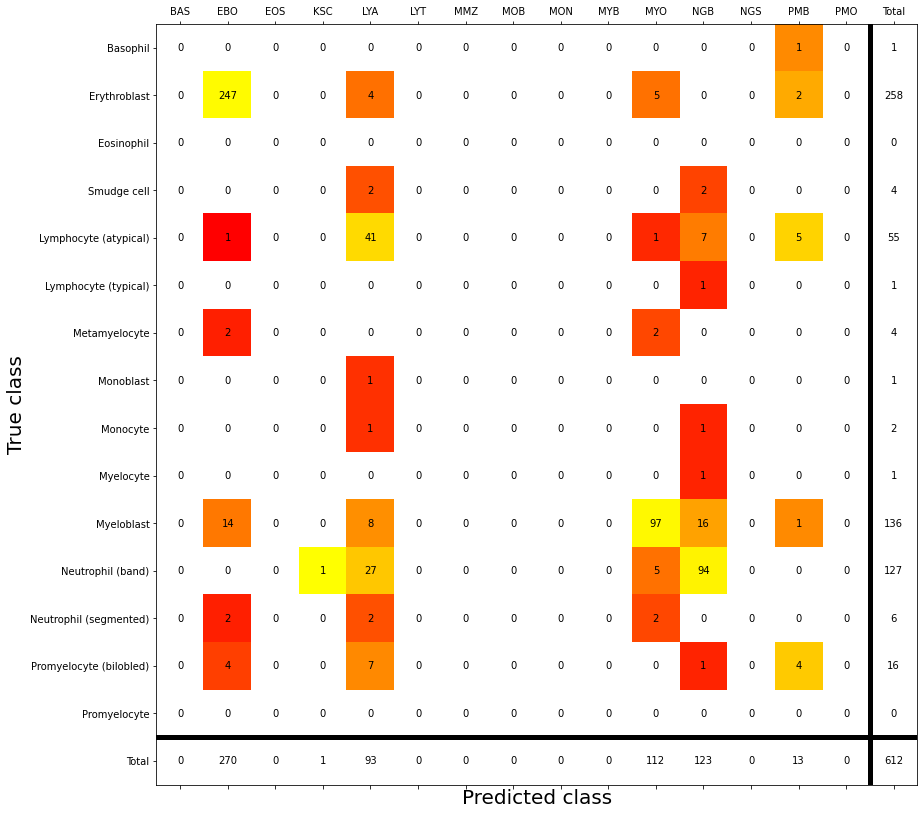

In [44]:
import matplotlib
from client.models.AMLmodel import classes as aml_classes

class_names_y = [aml_classes[k] for k in aml_classes] + ['Total']
class_names_x = [k for k in aml_classes] + ['Total']


def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.autumn):
    
    f, ax = plt.subplots(1,1,figsize=(20,14))
    color_mat = np.zeros(matrix.shape)
    color_mat[:15,:15] = matrix[:15,:15]/np.maximum(1,np.sum(matrix[:15,:15],0))
    ax.matshow(color_mat, cmap=cmap, norm=matplotlib.colors.LogNorm()) 

    tick_mark = np.arange(16)
    ax.set_xticks(tick_mark)
    ax.set_yticks(tick_mark)

    ax.set_xticklabels(class_names_x)
    ax.set_yticklabels(class_names_y)
    
    for (i, j), z in np.ndenumerate(matrix):
        
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

    ax.axvline(x=14.5,color='black',lw=5)
    ax.axhline(y=14.5,color='black', lw=5)
    ax.set_xlabel('Predicted class', fontsize=20)
    ax.set_ylabel('True class', fontsize=20)

M = confusion_matrix(model, test_gen)
plot_confusion_matrix(M)
plt.savefig('confusion_sample.png')